# NIRSpec/G395H Flux Calibration

This notebook will walk you through the additional steps necessary for flux calibration of NIRSpec/G395H BOTS observations.
Note that the process to follow will be the same for the other NIRSpec gratings (or PRISM) -- we're using G395H here as an example since that was the grating used in the JWST Transiting Exoplanet Community Early Release Science (ERS) program. 
This notebook also assumes that you've already worked through the NIRSpec/G395H reduction notebook and have produced the relevant outputs.

In [ ]:
# First thing to do is set your CRDS variables so we can download the most up-to-date JWST 
# reference files. 

import os
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Flux calibration converts the extracted stellar spectra into "real" units (e.g., erg/s/cm^2/µm) from the pipeline default "data numbers" (DN/s) or electrons (e/s). This invovles correcting the wavelength-dependent instrument throughput and applying the relevant unit conversions which were calibrated during commissioning using flux standard stars. 

We start this tutorial with the WaveCorrStep Stage 2 outputs from the NIRSpec/G395H reduction tutorial

In [ ]:
# Specify the input directory containing the WaveCorrStep outputs.

indir = 'pipeline_outputs_directory/Stage2/'

# Lists of the WaveCorrStep outputs for each segment.

filenames1 = [indir + 'jw01366003001_04101_00001-seg001_nrs1_wavecorrstep.fits',
              indir + 'jw01366003001_04101_00001-seg002_nrs1_wavecorrstep.fits',
              indir + 'jw01366003001_04101_00001-seg003_nrs1_wavecorrstep.fits']

filenames2 = [indir + 'jw01366003001_04101_00001-seg001_nrs2_wavecorrstep.fits',
              indir + 'jw01366003001_04101_00001-seg002_nrs2_wavecorrstep.fits',
              indir + 'jw01366003001_04101_00001-seg003_nrs2_wavecorrstep.fits']

<div class="alert alert-block alert-info"> <b>NOTE:</b> This tutotial starts with the WaveCorrStep outputs in Stage 2. However, you must also ensure to have run the GainScaleStep in Stage 1, or else the flux units at this point will be DN/s instead of the expected e-/s.</div>

Now let's create some new output directories. In this case, we'll make subdirectories in the Stage2 and Stage3 directories for the flux-calibrated products, to not confuse them with non-flux-calibrated outputs from the previous tutorial.

In [ ]:
from exotedrf import utils

# Generate output directories

utils.verify_path('pipeline_outputs_directory')
utils.verify_path('pipeline_outputs_directory/Stage2')
utils.verify_path('pipeline_outputs_directory/Stage2/FluxCalibrated')
utils.verify_path('pipeline_outputs_directory/Stage3')
utils.verify_path('pipeline_outputs_directory/Stage3/FluxCalibrated')

In [ ]:
# Now define the output directory paths

outdir_s2 = 'pipeline_outputs_directory/Stage2/FluxCalibrated/'
outdir_s3 = 'pipeline_outputs_directory/Stage3/FluxCalibrated/'

Now we're ready to start the flux calibration. There are a few steps that are dfferent fromt the normal workflow when producing flux calibrated outputs, including applying the flat field correction and flux calibration reference files. We skip these in the normal workflow since we care only about relative measurements when constructing atmosphere spectra.

## Flux Calibration Workflow

### Flat Field Correction Step
Applies the flat field correction.

In [ ]:
from exotedrf import stage2

# Run flat field correction.

step = stage2.FlatFieldStep(filenames1, output_dir=outdir_s2)

results1 = step.run(save_results=True, force_redo=True)

As with the previous tutorial, we're only going to run the steps for NRS1, and you can just swap the filename variable for NRS2.

### Photom Step
Applies the wavelength-dependent flux calibration reference file.

In [ ]:
# Run flux calibration.

step = stage2.PhotomStep(results1, output_dir=outdir_s2)

results1 = step.run(save_results=True, force_redo=True)

These are the two "new" steps that need to be run for flux calilbration. We'll now pick up where we left off in the original tutorial and proceed to extract the spectra. 

### Bad Pixel Correction Step
Interpolate any remaining bad pixels in the data to be ready for the spectral extraction.  

In [ ]:
# Interpolate bad pixels.

step = stage2.BadPixStep(results1, [150, -100], output_dir=outdir_s2)

results1 = step.run(save_results=True, force_redo=True, do_plot=False, space_thresh=15, time_thresh=10)

### PCA Reconstruction Step
Just to produce the data deep stack.

In [ ]:
# Produce a deep frame. We're not going to remove any components in this tutorial.

step = stage2.PCAReconstructStep(results1, baseline_ints=[150, -100], output_dir=outdir_s2)

results1, deepframe1 = step.run(save_results=True, force_redo=True)

### Tracing Step
Get the trace positions.

In [ ]:
# Trace the 2D spectrum on the detector. 

step = stage2.TracingStep(results1, deepframe=deepframe1, output_dir=outdir_s2)
 
centroids1 = step.run(save_results=True, force_redo=True)

### 1D Spectral Extraction
Now we're ready for the spectral extraction.

In [ ]:
# We now need the Stage 3 pipeline.

from exotedrf import stage3

In [ ]:
import pandas as pd

# Open the centroids file. 

centroids1 = pd.read_csv(outdir_s2 + 'jw01366003001_04101_00001_nrs1_centroids.csv', comment='#')

In [ ]:
# Extract the spectra.

step = stage3.Extract1DStep(results1, extract_method='box', output_dir=outdir_s3)

# The exact width used here is not super important. Use something similar to what you would for the 
# normal workflow.

spectra1 = step.run(extract_width=10, centroids=centroids1, save_results=True, force_redo=True)

After the intial extraction, there is one more step to do -- which is basically just a unit conversion.

In [ ]:
# Convert from MJy to erg/s/cm^2/µm

stage3.flux_calibrate('pipeline_outputs_directory/Stage3/WASP-39_nrs1_box_spectra_fullres.fits')

This step produces another spectrum file, but with the FluxCalibrated tag.  

Now you can just repeat all of the above for NRS2!

## Inspect Outputs

Let's unpack the extracted spectra and inspect the results. Here we're working with both NRS1 and NRS2 results, but you can just comment out the NRS2 stuff if you haven't run those steps yet.

In [ ]:
from astropy.io import fits
import numpy as np

# Open the flux calibrated spectrum files

spec_1 = fits.open('pipeline_outputs_directory/Stage3/WASP-39_nrs1_box_spectra_fullres_FluxCalibrated.fits')
spec_2 = fits.open('pipeline_outputs_directory/Stage3/WASP-39_nrs2_box_spectra_fullres_FluxCalibrated.fits')

# Get the wavelength axes.

wave1 = spec_1[1].data
wave2 = spec_2[1].data

# Trim the bluest wavelengths from NRS1.

ii = np.where(wave1 > 2.9)[0]
wave1 = wave1[ii]

In general, we want to work with the out-of-transit stellar spectra, so that there is no bias or imprint of the planet. 

In [ ]:
# Unpack the extracted spectra and median over the out-of-transit baseline (first 100 integrations).

spec1 = np.nanmedian(spec_1[3].data[:100, ii], axis=0)
spec2 = np.nanmedian(spec_2[3].data[:100], axis=0)

# We'll use the scatter along the time axis as the error.

spec_err1 = np.nanstd(spec_1[4].data[:100, ii], axis=0)
spec_err2 = np.nanstd(spec_2[4].data[:100], axis=0)

For a point of comparison, let's use a PHOENIX model.

In [ ]:
# Download a PHOENIX spectrum using the grid point closest to the parameters of WASP-39.

_ = utils.download_stellar_spectra(5500, 4.5, 0, './')

In [ ]:
# Open the PHOENIX spectra and wavelength files. 

mod_wave = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*1e-4  # Convert to µm
mod_spec = fits.getdata('lte05500-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')*1e-4 # Convert to µm

The extracted stellar spectra are measured at Earth (or close enough), whereas the PHEONIX models effectively provide flux at the surface of the star. So we need one more conversion to allow for an apples-to-apples comparison.

In [ ]:
# Rescale the PHOENIX model spectrum by the inverse-square law for flux. 

Rs = 0.939 * 6.96e8  # Radius of WASP-39 in m.
d = 213.982 * 3.086e16  # Distance to WASP-39 in m.

# Apply the flux rescaling.

mod_spec *= (Rs/d)**2

In [ ]:
from scipy.ndimage import gaussian_filter

# And let's smooth the model spectrum for visualization purposes. 

mod_spec = gaussian_filter(mod_spec, 25)

Now let's plot up the model and extracted stellar spectra.

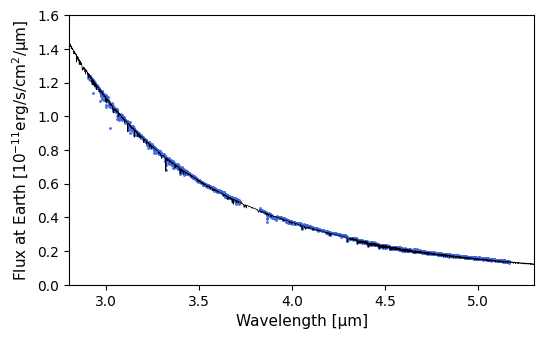

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3.5))

# Here we're trimming some edge effects from each detector.
# We're also rescaling the flux by ~2% to get a better match to the model spectrum. This is not unexpected 
# and can be due to e.g., stellar brightness variations.

plt.errorbar(wave1[:-5], spec1[:-5]/1.02*1e11, yerr=spec_err1[:-5]*1e11, 
             c='royalblue', ms=1, fmt='o')

plt.errorbar(wave2[7:-20], spec2[7:-20]/1.02*1e11, yerr=spec_err2[7:-20]*1e11, 
             c='royalblue', ms=1, fmt='o')

# And plot up the model spectrum

plt.plot(mod_wave, mod_spec*1e11, c='black', lw=0.5)

plt.xlim(2.8, 5.3)
plt.ylim(0, 1.6)
plt.ylabel(r'Flux at Earth [$\rm 10^{-11} erg/s/cm^2/µm$]', fontsize=11)
plt.xlabel('Wavelength [µm]', fontsize=11)
plt.show()

The match is pretty good!

And voilà, you now have a flux-calibrated stellar spectrum.